In [2]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [3]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

### Split Swithes

In [6]:
switch3 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp3",
            "egress_global_timestamp3",
            "enq_timestamp3",
            "enq_qdepth3",
            "deq_timedelta3",
            "deq_qdepth3",
        ]
    ]
)
switch2 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp2",
            "egress_global_timestamp2",
            "enq_timestamp2",
            "enq_qdepth2",
            "deq_timedelta2",
            "deq_qdepth2",
        ]
    ]
)
switch1 = (
    result_total[
        [
            "timestamp",
            "ingress_global_timestamp1",
            "egress_global_timestamp1",
            "enq_timestamp1",
            "enq_qdepth1",
            "deq_timedelta1",
            "deq_qdepth1",
        ]
    ]
)

In [31]:
def show_something(y1, z1, x1):
    data = {
        "Switch": switches,
        "RF_MAE": y1[:4],
        "RF_NMAE": y1[:4],
        "XGB_MAE": z1[:4],
        "XGB_NMAE": z1[:4],
    }
    df = pd.DataFrame(data)

    bar_width = 0.35
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots()
    bars_rf = ax.bar(
        r1, df["RF_NMAE"], color="blue", width=bar_width, edgecolor="white", label="RF"
    )
    bars_xgb = ax.bar(
        r2, df["XGB_NMAE"], color="red", width=bar_width, edgecolor="white", label="XGB"
    )

    ax.set_xlabel("Switch")
    ax.set_ylabel("NMAE (%)")
    ax.set_xticks([r + bar_width / 2 for r in range(len(df))])
    ax.set_xticklabels(df["Switch"])
    ax.legend()

    for bar in bars_rf:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval - 0.1,
            f"{yval:.1f}%",
            ha="center",
            va="bottom",
        )

    for bar in bars_xgb:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval - 0.1,
            f"{yval:.1f}%",
            ha="center",
            va="bottom",
        )
    plt.savefig("NoParamsRFvsXGB.png", dpi=fig.dpi)
    plt.show()
   

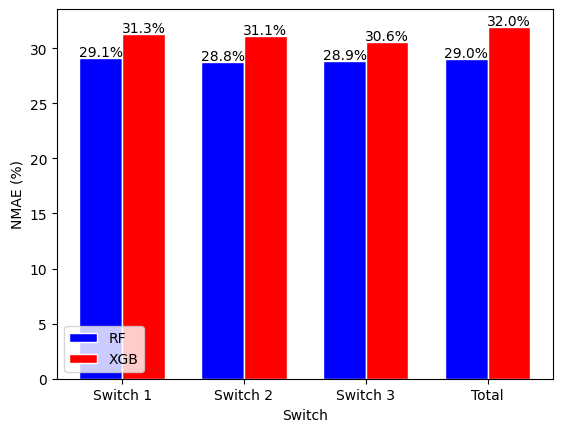

In [32]:
show_something(x1=x1, y1=y1, z1=z1)


### Models

In [11]:
def rf_train_model(features, labels):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features,
        np.ravel(labels),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        # n_estimators=500,
        # max_depth=50,
        # min_samples_split=2,
        # min_samples_leaf=1,
        bootstrap=True,
        # verbose=0,
        # max_features=1.0,
        # n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    
    return mae_rf, nmae_rf, rf_model, feature_importances

In [13]:
def xgb_train_model(dataOver, answer):
    X_train, X_validation, y_train, y_validation = train_test_split(
        dataOver,
        np.ravel(answer),
        test_size=0.30,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    xgb_model = XGBRegressor(
        # n_estimators=1000,
        # learning_rate=0.01,  
        # max_depth=30, 
        # n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        xgb_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )
    avg_cv_score = np.mean(cv_scores)

    xgb_model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_validation_scaled, y_validation)],
        verbose=False
    )

    y_pred = xgb_model.predict(X_validation_scaled)
    mae = mean_absolute_error(y_validation, y_pred)
    nmae = mae / np.mean(y_validation)

    feature_importances = xgb_model.feature_importances_
    return mae, nmae, xgb_model, feature_importances

### Tests

Switch 1 RF-> MAE: 5.866, NMAE: 29.138%
Switch 2 RF-> MAE: 5.792, NMAE: 28.769%
Switch 3 RF-> MAE: 5.813, NMAE: 28.876%
Total RF-> MAE: 5.848, NMAE: 29.049%
[0]	validation_0-rmse:10.78911
[1]	validation_0-rmse:10.40560
[2]	validation_0-rmse:10.26195
[3]	validation_0-rmse:10.18563
[4]	validation_0-rmse:10.09765
[5]	validation_0-rmse:10.00291
[6]	validation_0-rmse:9.99165
[7]	validation_0-rmse:9.96850
[8]	validation_0-rmse:9.92943
[9]	validation_0-rmse:9.86252
[10]	validation_0-rmse:9.83086
[11]	validation_0-rmse:9.82433
[12]	validation_0-rmse:9.75944
[13]	validation_0-rmse:9.73578
[14]	validation_0-rmse:9.70376
[15]	validation_0-rmse:9.68400
[16]	validation_0-rmse:9.65014
[17]	validation_0-rmse:9.62824
[18]	validation_0-rmse:9.60841
[19]	validation_0-rmse:9.59050
[20]	validation_0-rmse:9.58396
[21]	validation_0-rmse:9.56166
[22]	validation_0-rmse:9.56345
[23]	validation_0-rmse:9.56504
[24]	validation_0-rmse:9.52697
[25]	validation_0-rmse:9.53081
[26]	validation_0-rmse:9.50733
[27]	valid

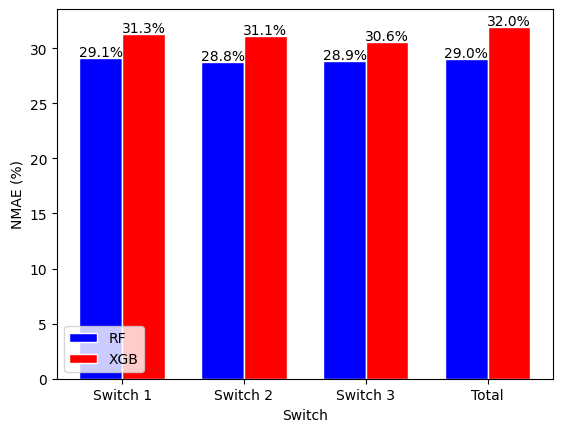

<Figure size 640x480 with 0 Axes>

In [16]:
switches = ["Switch 1", "Switch 2", "Switch 3", "Total"]
x1 = [1, 2, 3, 4]
y1, z1 = [], []

result_ = result_total.copy(True)
models = {
    "RF": [],
    "XGB": []
}
feature_importances = {
    "RF": [],
    "XGB": []
}
results_rf = [switch1, switch2, switch3, result_]
results_xgb = [switch1, switch2, switch3, result_]

def collect_metrics(train_func, results, y_list, model_name):
    for i, result in enumerate(results):
        mae, nmae, model, feature_importance = train_func(result, labels)
        y_list.append(nmae * 100)
        models[model_name].append(model)
        feature_importances[model_name].append(feature_importance)
        print(f"{switches[i]} {model_name}-> MAE: {mae:.3f}, NMAE: {nmae * 100:.3f}%")
try:
    collect_metrics(rf_train_model, results_rf, y1, "RF")
    collect_metrics(xgb_train_model, results_xgb, z1, "XGB")
    show_something(x1=x1, y1=y1, z1=z1)
    alert_end()
except Exception as e:
    alert_end()


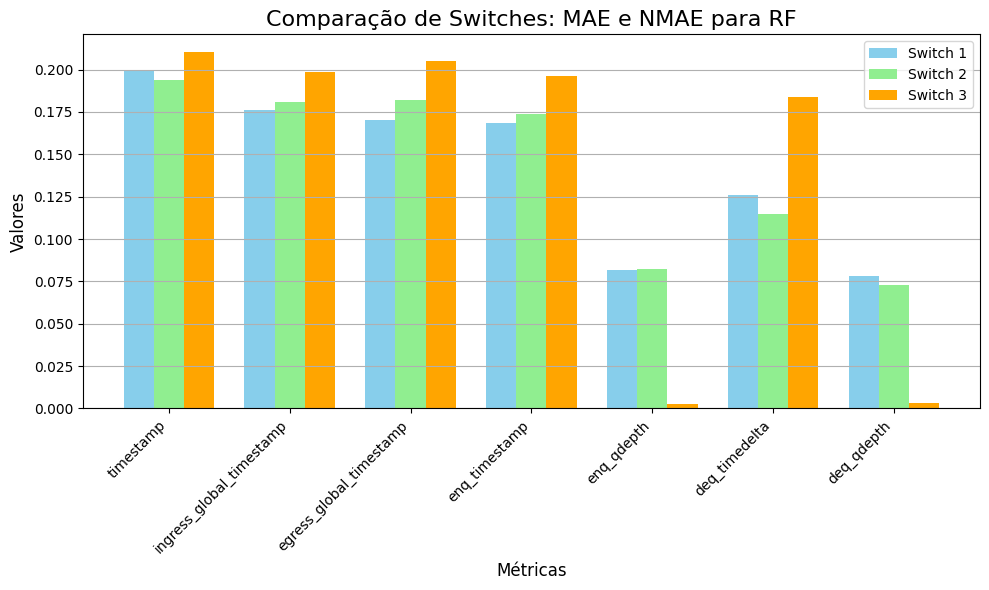

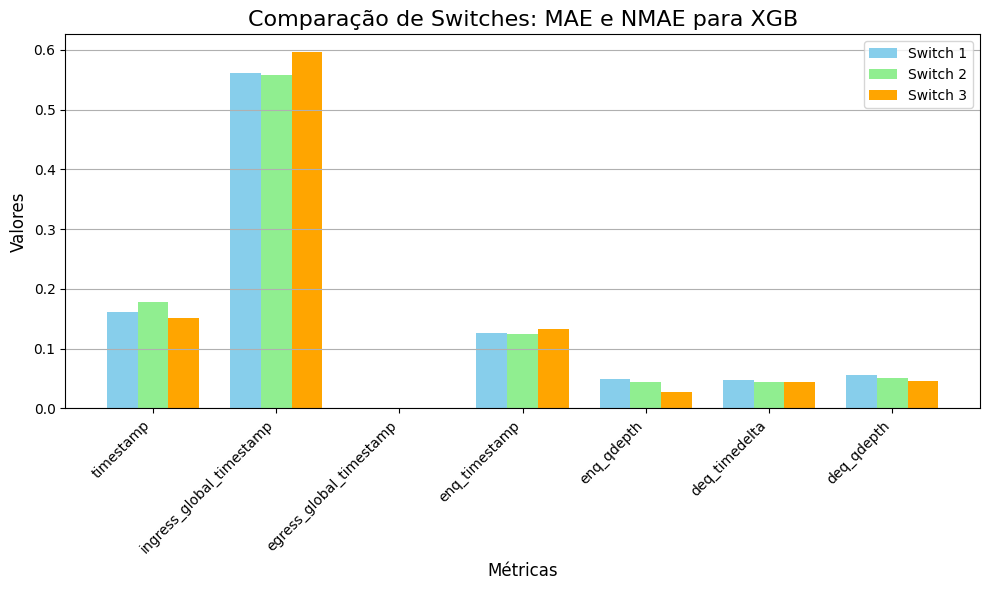

In [25]:
switch1_features = list(feature_importances['RF'][0])
switch2_features = list(feature_importances['RF'][1])
switch3_features = list(feature_importances['RF'][2])


labels = ['timestamp', 'ingress_global_timestamp', 'egress_global_timestamp', 
          'enq_timestamp', 'enq_qdepth', 'deq_timedelta', 'deq_qdepth']

x = np.arange(len(labels))

width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, switch1_features, width, label='Switch 1', color='skyblue')
plt.bar(x, switch2_features, width, label='Switch 2', color='lightgreen')
plt.bar(x + width, switch3_features, width, label='Switch 3', color='orange')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title('Comparação de Switches: MAE e NMAE para RF', fontsize=16)
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

switch1_features = list(feature_importances['XGB'][0])
switch2_features = list(feature_importances['XGB'][1])
switch3_features = list(feature_importances['XGB'][2])
x = np.arange(len(labels))
width = 0.25
plt.figure(figsize=(10, 6))
plt.bar(x - width, switch1_features, width, label='Switch 1', color='skyblue')
plt.bar(x, switch2_features, width, label='Switch 2', color='lightgreen')
plt.bar(x + width, switch3_features, width, label='Switch 3', color='orange')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title('Comparação de Switches: MAE e NMAE para XGB', fontsize=16)
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()